In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
df = pd.read_csv(r"Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250526.csv")

In [57]:
df

,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,30/08/2024,16436,10705,225,19026,3925,59.0
1,15/09/2023,15499,10671,267,18421,4519,61.0
2,28/12/2021,1756,2352,0,3775,0,13.0
3,11/01/2023,10536,8347,223,14072,0,48.0
4,11/09/2021,820,612,0,1283,0,11.0
...,...,...,...,...,...,...,...
1913,19/01/2023,11337,8671,262,14881,0,66.0
1914,16/08/2023,16791,11800,387,20936,4684,113.0
1915,10/01/2022,5732,3548,73,6644,0,25.0
1916,04/05/2020,3717,1952,70,4411,131,19.0


<Figure size 1400x800 with 0 Axes>

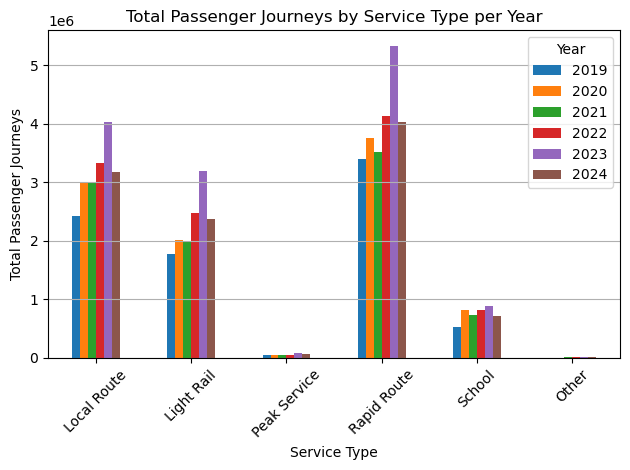

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df['Year'] = df['Date'].dt.year
yearly_service_data = df.groupby('Year')[['Local Route', 'Light Rail', 'Peak Service', 
                                          'Rapid Route', 'School', 'Other']].sum()

yearly_service_data_T = yearly_service_data.T


plt.figure(figsize=(14, 8))
yearly_service_data_T.plot(kind='bar')
plt.title('Total Passenger Journeys by Service Type per Year')
plt.xlabel('Service Type')
plt.ylabel('Total Passenger Journeys')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [59]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
df.set_index('Date', inplace=True)

In [60]:
df

,Local Route,Light Rail,Peak Service,Rapid Route,School,Other,Year
Date,,,,,,,
2019-07-01,15987,9962,407,21223,3715,NaN,2019
2019-07-02,16895,10656,409,21715,3993,NaN,2019
2019-07-03,16613,10658,427,22025,3638,NaN,2019
2019-07-04,16604,10445,437,21868,3576,NaN,2019
2019-07-05,16040,10532,400,20697,2856,NaN,2019
...,...,...,...,...,...,...,...
2024-09-25,21,0,1,10,8,NaN,2024
2024-09-26,9,0,0,0,2,NaN,2024
2024-09-27,6,0,0,13,0,NaN,2024


In [61]:
df.corr()

,Local Route,Light Rail,Peak Service,Rapid Route,School,Other,Year
Local Route,1.000000,0.918795,0.944390,0.965122,0.852356,0.472877,0.078901
Light Rail,0.918795,1.000000,0.879347,0.967736,0.685795,0.426106,0.191270
Peak Service,0.944390,0.879347,1.000000,0.944997,0.728795,0.380760,0.038888
Rapid Route,0.965122,0.967736,0.944997,1.000000,0.754290,0.382616,0.072906
School,0.852356,0.685795,0.728795,0.754290,1.000000,0.430711,0.010016
Other,0.472877,0.426106,0.380760,0.382616,0.430711,1.000000,0.407383
Year,0.078901,0.191270,0.038888,0.072906,0.010016,0.407383,1.000000


In [62]:
df1 = df.drop(["Other"],axis=1)

In [63]:
df1

,Local Route,Light Rail,Peak Service,Rapid Route,School,Year
Date,,,,,,
2019-07-01,15987,9962,407,21223,3715,2019
2019-07-02,16895,10656,409,21715,3993,2019
2019-07-03,16613,10658,427,22025,3638,2019
2019-07-04,16604,10445,437,21868,3576,2019
2019-07-05,16040,10532,400,20697,2856,2019
...,...,...,...,...,...,...
2024-09-25,21,0,1,10,8,2024
2024-09-26,9,0,0,0,2,2024
2024-09-27,6,0,0,13,0,2024


In [64]:
def forecast_service(data, service_name, steps=7):
    ts = data[service_name]

    model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,7))
    model_fit = model.fit(disp=False)
    forecast = model_fit.get_forecast(steps=steps)
    forecast_values = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    return forecast_values, conf_int

In [65]:
services = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']
forecasts = {}
confidence_intervals = {}

for service in services:
    forecast_values, conf_int = forecast_service(df, service)
    forecasts[service] = forecast_values
    confidence_intervals[service] = conf_int

C:\Users\prane\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\prane\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\prane\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\prane\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\prane\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D w

In [ ]:
forecast_df = pd.DataFrame({
    'Date': next_dates,
    'Local Route': forecasts['Local Route'].values,
    'Light Rail': forecasts['Light Rail'].values,
    'Peak Service': forecasts['Peak Service'].values,
    'Rapid Route': forecasts['Rapid Route'].values,
    'School': forecasts['School'].values
})

In [67]:
print("7-Day Forecast for Public Transport Services:")
print(forecast_df.set_index('Date').round(0))

7-Day Forecast for Public Transport Services:
            Local Route  Light Rail  Peak Service  Rapid Route  School
Date                                                                  
2024-09-30       3693.0      2342.0         151.0       3816.0  1640.0
2024-10-01       4139.0      2379.0         158.0       4340.0  1879.0
2024-10-02       3916.0      2319.0         154.0       3964.0  1912.0
2024-10-03       3579.0      1992.0         118.0       3589.0  1838.0
2024-10-04       2800.0      1108.0          53.0       1421.0  1706.0
2024-10-05      -3595.0     -1907.0        -104.0      -4548.0    17.0
2024-10-06      -4650.0     -3005.0        -104.0      -5669.0    18.0


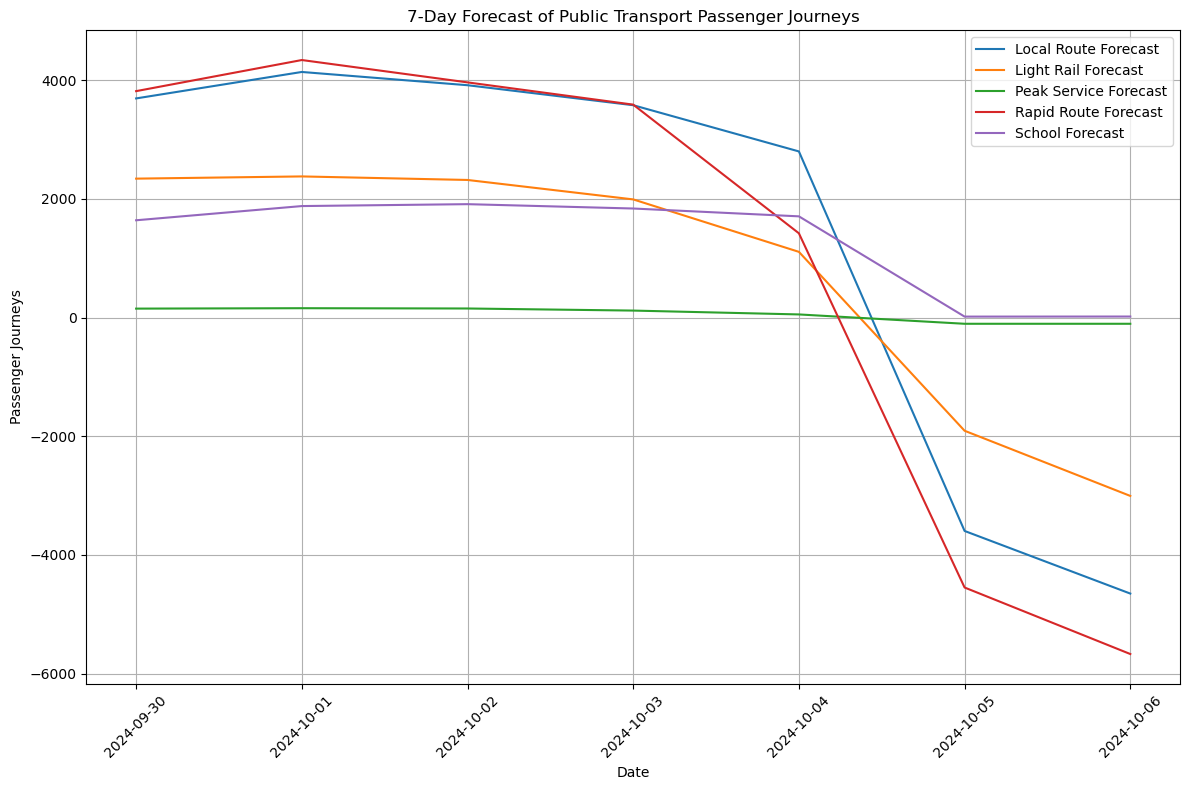

In [68]:
plt.figure(figsize=(12, 8))
for service in services:
    plt.plot(forecast_df['Date'], forecast_df[service], label=f'{service} Forecast')
    
plt.title('7-Day Forecast of Public Transport Passenger Journeys')
plt.xlabel('Date')
plt.ylabel('Passenger Journeys')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()